# Key Lessons

1. Finetuning a pre-trained Mask R-CNN model.
2. Defining the dataset with `torch.utils.data.Dataset`.

Training vs. Evaluation
- Training: Models are only punished (via loss functions) for incorrect predictions. There's no explicit "reward" - good predictions simply avoid punishment.
- Evaluation: Metrics like mAP measure performance, where "reward" and "punishment" are implicit:
   - Reward: True positives (correct detections) increases precision/recall.
   - Punishment: False positives/negatives decreases precision/recall.

target: a dict containing the following fields
- `iscrowd`, uint8 `torch.Tensor` of shape `[N]`: instances with `iscrowd=True` will be ignored during evaluation.
  - Use `iscrowd=True` only for regions where individual annotations is impossible (e.g. due to extreme density, occlusion, or ambiguity).
    - Examples of valid `iscrowd=True`:
      - A dense crowd of people where individual boxes would overlap heavily.
      - A pile of objects (e.g., apples in a bin) where separating instances is impractical.
    - Examples of invalid `iscrowd=True`:
      - A group of people where some are clearly visible and annotated, but others are unannotated due to oversight or laziness.
  - Example Workflow
    - Image: A park scene with:
      - 1 annotated dog (iscrowd=False).
      - A crowd containing:
        - 5 annotated individuals (iscrowd=False).
        - A dense subgroup of 50 people (too packed to annotate individually).

In [ ]:
import os

if not os.path.exists("data"):
  os.mkdir("data")

file_path = "data/PennFudanPed.zip"
if not os.path.exists(file_path):
  os.system("curl -o %s %s" % (file_path, "https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip"))

if not os.path.exists("data/PennFudanPed") and os.path.exists(file_path):
  os.system("unzip %s -d data" % file_path)

del file_path

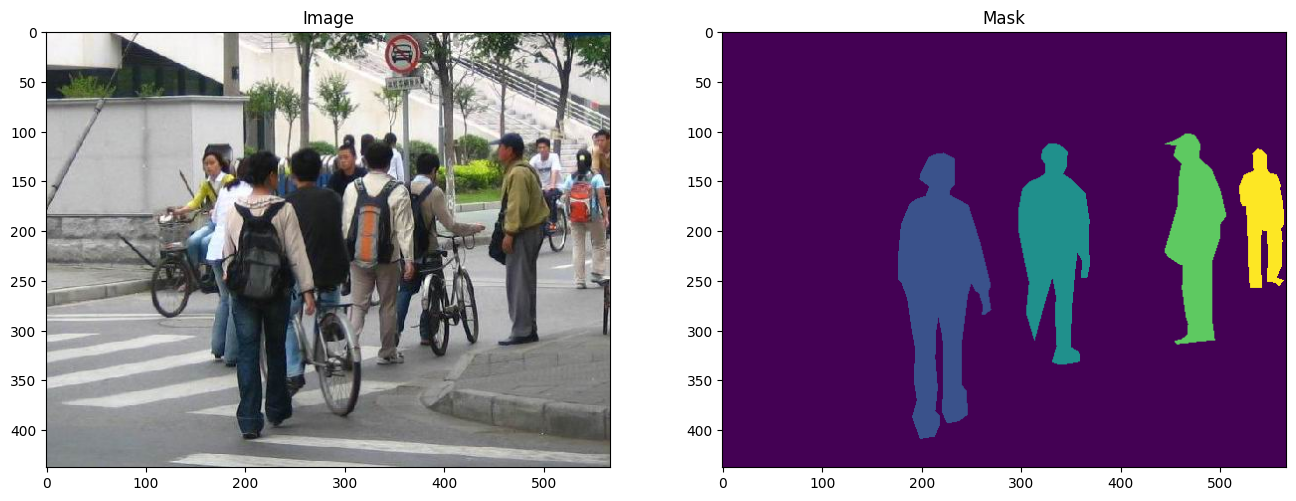

In [2]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

image = read_image("data/PennFudanPed/PNGImages/FudanPed00046.png") # returns: CxHxW (C=3)
mask = read_image("data/PennFudanPed/PedMasks/FudanPed00046_mask.png") # returns: CxHxW (C=1)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))

plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask.permute(1,2,0))

In [3]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms.v2 import Compose

class PennFudanDataset(torch.utils.data.Dataset):
  """
  - chore: naming convention

  reference:
  1. https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
  """
  def __init__(self, rootFilePath: str, transforms: Compose | None = None):
    self.root = rootFilePath
    self.transforms = transforms
    # load all image files, sorting them to
    # ensure that they are aligned
    self.images = list(sorted(os.listdir(os.path.join(rootFilePath, "PNGImages"))))
    self.masks = list(sorted(os.listdir(os.path.join(rootFilePath, "PedMasks"))))

  def __getitem__(self, index: int):
    # load images and masks
    image_file_path = os.path.join(self.root, "PNGImages", self.images[index])
    mask_file_path = os.path.join(self.root, "PedMasks", self.masks[index])
    image = read_image(image_file_path)
    mask = read_image(mask_file_path)
    # instances are encoded as different colors
    object_indices = torch.unique(mask)
    # first id is the background, so remove it
    object_indices = object_indices[1:]
    object_count = len(object_indices)

    # split the color-encoded mask into a set
    # of binary masks
    masks = (mask == object_indices[:, None, None]).to(dtype=torch.uint8)

    # get bounding box coordinates for each mask
    boxes = masks_to_boxes(masks)

    # there is only one class 
    # because the PennFudan dataset only has one class of objects to detect: pedestrians
    labels = torch.ones((object_count,), dtype=torch.int64)

    image_id = index
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    # suppose all instances are not crowd
    iscrowd = torch.zeros((object_count,), dtype=torch.int64)

    # Wrap sample and targets into torchvision tv_tensors:
    image = tv_tensors.Image(image)

    target = {}
    target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(image))
    target["masks"] = tv_tensors.Mask(masks)
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms is not None:
      image, target = self.transforms(image, target)

    return image, target

  def __len__(self):
    return len(self.images)

# Defining your model

1. Using Mask R-CNN, which is based on top of Faster R-CNN. Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.
2. Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

# 1 - Finetuning from a pretrained model

`model.roi_heads`: region of interest heads. These are components of the model that take the features extracted by the backbone network and the propoed regions (RoIs) and perform the final classification and bounding box regression.
`model.roi_heads.box_predictor` is the component responsible for predicting the class scores and bounding box coordinates.
`FastRCNNPredictor` is used to create a new predictor with the specified number of classes (`num_classes`), repalcing the pre-trained one.

In [ ]:
if not os.path.exists("weights"):
  os.makedirs("weights")

file_path = "weights/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth"
if not os.path.exists(file_path):
  os.system("curl -o %s %s" % (file_path, "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth"))

# Check the SHA256 hash of the downloaded file
# Expected: 258fb6c6
os.system("openssl dgst -sha256 %s" % (file_path))

del file_path

SHA2-256(weights/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth)= 258fb6c638b15964ddcdd1ae0748c5eef1be9e732750120cc857feed3faac384


In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights

# load a model pre-trained on COCO
# - hotfix: invalid hash value
#   manually download the weights from https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
#   check the hash value of the downloaded file with `$ openssl dgst -sha256 <filename>`
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
model.load_state_dict(torch.load("weights/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth"))

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features 
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# 2 - Modifying the model to add a different backbone

Full Pipeline
1. Backbone (MobileNetV2): Extracts feature maps from the input image.
2. RPN with Anchors: Generates region proposals (from `H x W x 15` anchors)
3. RoI Pooling: Converts proposals into fixed-size (7x7) feature grids.
4. Detection Head: Classifies proposals and refines bounding boxes.

Faster R-CNN uses the backbone's output channels to construct two critical components:
1. Region Proposal Network (RPN):

   The RPN's convolutional layers must match the backbone's output channels to process feature maps correctly.

2. Detection Head:

   The classifier and regressor heads depend on the backbone's feature dimensions to compute class scores and box offsets.

What is RPN?
- RPN generates candidate object regions ("proposal") from feature maps.
- It predicts:
  - Objectness score: Likelihood a region contains an object.
  - Bounding box adjustments: Offsets to refine anchor boxes.

Non-Maximum Suppression (NMS) is applied to remove redundant proposals (e.g., keep top 1000-2000 proposals)

In [6]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
# MobileNetV2's `.features` backbone ends with a final convolutional layer that always outputs 1280 channels by design.
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
# anchors are pre-defined bounding boxes of varying sizes/aspect ratios placed at
# every spatial location (pixel) in the feature map
# total anchors per spatial location: 5 sizes x 3 ratios = 15 anchors
# a spatial location is a position (pixel) in the feature map.
anchor_generator = AnchorGenerator(
  sizes=((32, 64, 128, 256, 512),),
  aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
# MultiScaleRoIAlign is used for ROI pooling. It takes regions of interest
# from different feature map levels and resizes them to a fixed size (output_size=7).
# sampling_ratio=2 means using 2x2 sampling points in each bin for
# bilinear interpolation, balancing detail and computation.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
  featmap_names=['0'],
  output_size=7,
  sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
  backbone,
  num_classes=2,
  rpn_anchor_generator=anchor_generator,
  box_roi_pool=roi_pooler
)

# Object detection and instance segmentation model for PennnFudan Dataset

In [7]:
file_path = "weights/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth"

if not os.path.exists(file_path):
  os.system("curl -o %s %s" % (file_path, "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth"))

del file_path

In [8]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes: int):
  # load an instance segmentation model pre-trained on COCO
  # model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=None)
  model.load_state_dict(torch.load("weights/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth"))

  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  # now get the number of input features for the mask classifier
  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256 # 256 is a design choice, can be changed
  # and replace the mask predictor with a new one
  model.roi_heads.mask_predictor = MaskRCNNPredictor(
    in_features_mask,
    hidden_layer,
    num_classes
  )

  return model

In [9]:
if not os.path.exists("detection"):
  os.makedirs("detection")
file_path = "detection/engine.py"
if not os.path.exists(file_path):
  os.system("curl -o %s %s" % (file_path, "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py"))
file_path = "detection/utils.py"
if not os.path.exists(file_path):
  os.system("curl -o %s %s" % (file_path, "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py"))
file_path = "detection/coco_utils.py"
if not os.path.exists(file_path):
  os.system("curl -o %s %s" % (file_path, "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py"))
file_path = "detection/coco_eval.py"
if not os.path.exists(file_path):
  os.system("curl -o %s %s" % (file_path, "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py"))
file_path = "detection/transforms.py"
if not os.path.exists(file_path):
  os.system("curl -o %s %s" % (file_path, "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py"))

del file_path

In [10]:
from torchvision.transforms import v2 as T

def get_transform(train: bool):
  transforms = []
  if train:
    transforms.append(T.RandomHorizontalFlip(0.5))
  transforms.append(T.ToDtype(torch.float, scale=True))
  transforms.append(T.ToPureTensor())
  return T.Compose(transforms)

# Testing forward() method (Optional)

loss_box_reg
- What it is: The bounding box regression loss for refined object detection boxes (second stage of models like Faster/Mask R-CNN)
- Purpose: Measures how well the model adjusts the coordinates of predicted bounding boxes to tightly fit objects. Uses a smooth L1 loss.

loss_mask:
- What it is: The segmentation mask loss (specific to Mask R-CNN)
- Purpose: Measures pixel-wise accuracy of predicted masks for detected objects. Uses binary cross-entropy or dice loss

loss_objectness:
- What it is: The Region Proposal Network (RPN)'s objectness loss.
- Purpose: Measures the RPN's ability to distinguish foreground (objects) from background regions. A binary classification loss (e.g, cross-entropy)

loss_rpn_box_reg:
- What it is: The bounding box regression loss for RPN proposals (first stage).
- Purpose: Measures how well the RPN adjusts anchor boxes to fit potential objects. Uses smooth L1 loss.

data:
- What it is: Time (in seconds) spent loading/preprocessing data per batch.
- Purpose: Helps identify bottlenecks. High values mean the data pipeline is slowing training.

Key Concepts:
- RPN: Generates region proposals (loss_objectness, loss_rpn_box_reg)
- Detection Head: Classifies objects and refines boxes (loss_classifier, loss_box_reg)
- Mask Head: Predicts segmentation masks (loss_mask)

creating index... / index created!
- What it means:
  - During evaluation, the model generates predictions (bounding boxes, masks, etc.) for all images in the validation/test set. These predictions need to be organized into a structured format (an "index") to compare them against the ground-truth annotations efficiently.
  - The "index" typically stores predictions and their metadata (e.g., image IDs, confidence scores) for fast lookup during metric computation.
  - This step is part of the COCO evaluation pipeline and happens once per epoch to prepare for calculating metrics liek AP/AR.

Why are there multiple Average Precision (AP) values?
- AP is not a single number—it depends on three factors:
  - IoU Threshold: how strict the overlap requirement is between predictions and ground truth.
  - Object Size: Evaluates performance on small, medium, or large objects.
  - Max Detections (maxDets): How many predictions are considered per image.
- AP@0.50:0.95 = 0.724 is the primary metric.
- AP@0.50 = 0.989 shows the model performs well with loose overlap requirements.
- AP@0.75 = 0.873 indicates decent performance under strict localization.
- AP=-1.000 for small objects suggets your dataset has none (common in COCO-style evaluations if small objects are filtered out).

Recall (AR)
- AR@maxDets=1 (0.292) is low because the model is forced to pick just 1 detection per image.
- AR@maxDets=100 (0.769) shows better recall when allowed more predictions.

Why Do Object Sizes Matter?
- Detection Difficulty: Smaller objects are harder to detect due to limited pixel information.
- Diagnostic Insight: Evaluating AP/AR by size helps identify weaknesses (e.g., a model strugles with small objects).
- Dataset Biases: Some datasets (e.g., satellite imagery) may prioritze small objects, while others (e.g., self-driving datasets) focus on medium/large objects.

In [11]:
import detection.utils as utils

# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
model.load_state_dict(torch.load("weights/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth"))
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
  dataset,
  batch_size=2,
  shuffle=True,
  collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print("training", output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)] # Image sizes are expected to vary
predictions = model(x)  # Returns predictions
print("inference", predictions[0])

training {'loss_classifier': tensor(0.1557, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0197, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0106, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0023, grad_fn=<DivBackward0>)}
inference {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [12]:
from detection.engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = (torch.device('cuda') if torch.cuda.is_available() else
          torch.device('cpu'))

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50]) # leave 50 samples for testing
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:]) # use the remaining 50 samples for testing

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
  dataset,
  batch_size=2,
  shuffle=True,
  collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
  dataset_test,
  batch_size=1,
  shuffle=False,
  collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad] # only parameters that are actually trainable
optimizer = torch.optim.SGD(
  params,
  lr=0.005,
  momentum=0.9,
  weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
  optimizer,
  step_size=3,
  gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
  # train for one epoch, printing every 10 iterations
  train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
  # update the learning rate
  lr_scheduler.step()
  # evaluate on the test dataset
  evaluate(model, data_loader_test, device=device)

print("That's it!")

/kaggle/working/learn-pytorch/1-torchvision/detection/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/60]  eta: 0:00:55  lr: 0.000090  loss: 3.6660 (3.6660)  loss_classifier: 0.5781 (0.5781)  loss_box_reg: 0.2708 (0.2708)  loss_mask: 2.8006 (2.8006)  loss_objectness: 0.0133 (0.0133)  loss_rpn_box_reg: 0.0032 (0.0032)  time: 0.9320  data: 0.0278  max mem: 2153
Epoch: [0]  [10/60]  eta: 0:00:28  lr: 0.000936  loss: 1.1899 (1.8886)  loss_classifier: 0.3524 (0.3815)  loss_box_reg: 0.2582 (0.2679)  loss_mask: 0.6697 (1.2159)  loss_objectness: 0.0133 (0.0196)  loss_rpn_box_reg: 0.0032 (0.0037)  time: 0.5772  data: 0.0294  max mem: 2939
Epoch: [0]  [20/60]  eta: 0:00:22  lr: 0.001783  loss: 0.9288 (1.3502)  loss_classifier: 0.2199 (0.2824)  loss_box_reg: 0.2331 (0.2589)  loss_mask: 0.3950 (0.7851)  loss_objectness: 0.0112 (0.0179)  loss_rpn_box_reg: 0.0048 (0.0059)  time: 0.5445  data: 0.0280  max mem: 2939
Epoch: [0]  [30/60]  eta: 0:00:16  lr: 0.002629  loss: 0.5499 (1.0677)  loss_classifier: 0.1044 (0.2178)  loss_box_reg: 0.2108 (0.2411)  loss_mask: 0.2103 (0.5885)  loss_ob

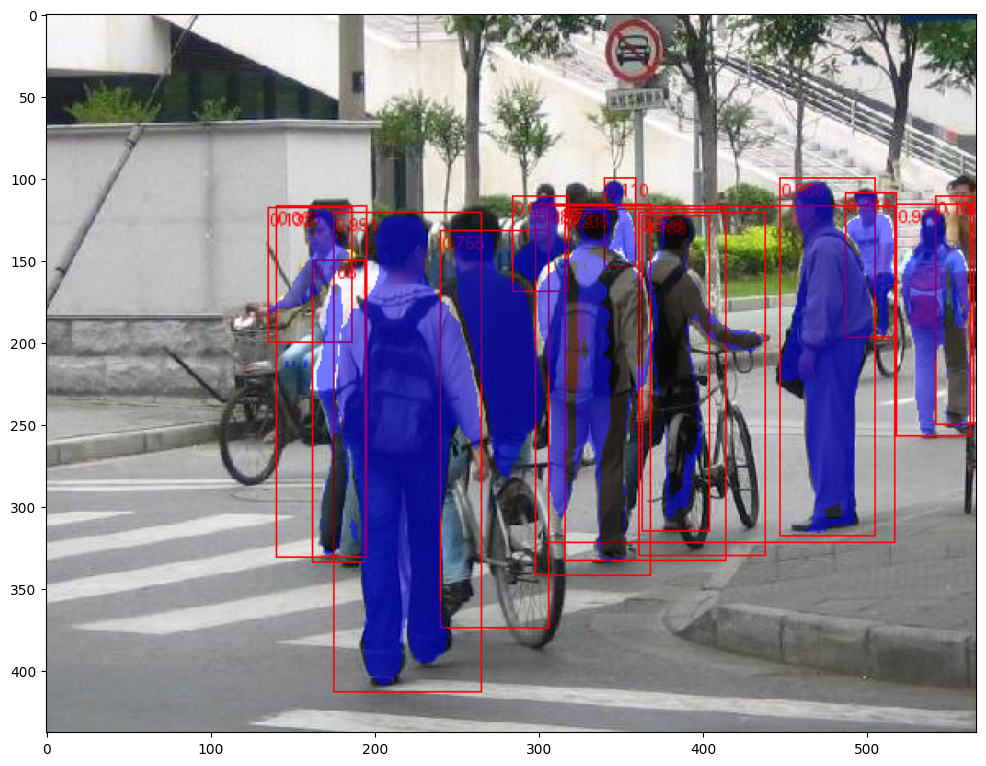

In [13]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("data/PennFudanPed/PNGImages/FudanPed00046.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
  x = eval_transform(image)
  # convert RGBA -> RGB and move to device
  # selects the first three channels of the tensor `x`.
  # The ellipsis (...) represents all the remaining dimensions.
  # So, if `x` is an image tensor with a shaoe like [C, H, W], this operation
  # extracts the first three channels (For example, converting a 4-channel RGBA image
  # to a 3-channel RGB image).
  # If your tensor already has three channels, the shape remains unchanged.
  x = x[:3, ...].to(device)
  predictions = model([x, ])
  pred = predictions[0]

# convert to 0-255
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"{score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))